# Imports

In [1]:
# runs on python 3.11; other versions not yet tested
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

# Functions

## Global Layer
Extracting images of all individual cell blobs and returning them in an array

In [2]:
def global_layer_imaginary_boarder(video_file_path, video_save_path, PICTURES_ON = True):
    # video_file_path: Current location of video
    # video_save_path: Location where video should be saved
    # PICTURES_ON: give back output or not

    # Object detection from Stable camera
    object_detector = cv2.createBackgroundSubtractorMOG2(history=1000000, varThreshold=40)

    # Create a VideoCapture object
    video = cv2.VideoCapture(video_file_path)

    # Output videos
    # result_roi = cv2.VideoWriter('cell_video_roi_3_frames.avi', 
    #                             cv2.VideoWriter_fourcc(*'MJPG'),
    #                             10, (1000,1000))
    result_frame = cv2.VideoWriter(video_save_path+'.avi', 
                            cv2.VideoWriter_fourcc(*'MJPG'),
                            10, (2048, 2048))
    # result_mask = cv2.VideoWriter('cell_video_result_3_frames.avi', 
    #                         cv2.VideoWriter_fourcc(*'MJPG'),
    #                         10, (1000,1000))

    # Check, if video was really opened or if file was corrupted
    if not video.isOpened():
        print("Error opening video file")

    # Get first frame of the video, necessary to get into "while" loop
    ret, frame = video.read()
    if not ret:
        print("Error reading frame")

    highest_id_so_far = 0 # Counter for cell number
    frame_no = 0 # Counter for frame number
    roi_per_blob_id = [] # Store image of bounding box / cell blob
    center_points = [] # Store the center positions of the objects
    id_count = 0 # Keep the count of the individual bounding boxes / cell blobs. Each time a new object id detected, the count will increase by one
    crit_distance = 30 # earlier: 25

    # distances = []

    while frame is not None:
        frame_no += 1

        # Extract Region of interest
        roi = frame[500:1500, 500:1500] # Total frame is 2048:2048
        roi[200:800, 200:800] = 0 

        # Start object_detector, go through blurring and filtering steps
        mask = object_detector.apply(roi)
        mask = cv2.GaussianBlur(mask, (3,3), 0) # test, to see if threshold picture gets more smooth
        _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) #d, my previous trial: 40

        # Morphological Ops: Either Dilation or Closing (Dilation then Erosion)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        mask = cv2.dilate(mask,kernel,iterations = 1)

        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_center_points = [] 

        for cnt in contours:
            area = cv2.contourArea(cnt) # Calculate area and remove small elements
            if area > 400: #1256: #area of kernel: 1256. The area should at least be bigger than five kernels... 
                x, y, w, h = cv2.boundingRect(cnt)

                center_of_gravity_y = int(y+h/2)
                center_of_gravity_x = int(x+w/2)

                # # New experiment: Have only a limited band, in which detections are truely counted, so that no "partial cells" at the edges of the ring are counted. Reduced number significantly
                if (center_of_gravity_x > 50 and center_of_gravity_x < 950): 
                    if (center_of_gravity_y > 50) and (center_of_gravity_y < 950):  
                        if (center_of_gravity_x < 150) or (center_of_gravity_x > 850) or (center_of_gravity_y < 150) or (center_of_gravity_y > 850): 

                            # Object Tracking: Find out if that object was detected already by itterating through the currently known cells. 
                            same_object_detected = False

                            for id, center_point, box in center_points:
                                dist = math.hypot(center_of_gravity_x - center_point[0], center_of_gravity_y - center_point[1])
                                if dist < crit_distance:
                                    same_object_detected = True
                                    new_center_points.append((id, (center_of_gravity_x, center_of_gravity_y), (x,y,w,h)))
                                    break

                            if same_object_detected is False:
                                new_center_points.append((id_count, (center_of_gravity_x, center_of_gravity_y), (x,y,w,h)))
                                roi_per_blob_id.append((id_count, roi.copy(), (x, x+w, y, y+h)))
                                id_count += 1

                # Outputing current box to user in understandable format
                cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 255), 0) # yellow frame
                cv2.circle(roi,(int(center_of_gravity_x), int(center_of_gravity_y)), 2, (0,255,255))

        # Update the current center_points
        center_points = new_center_points.copy()

        # Adding visual marks for user
        for box in center_points:
            id = box[0]
            x, y, w, h = box[2]
            cv2.putText(roi, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
            if highest_id_so_far < id: 
                highest_id_so_far = id

        # Markup video for better visual understanding
        cv2.rectangle(roi, (50, 50), (950, 950), (255, 255, 255), 0)
        cv2.rectangle(roi, (150, 150), (850, 850), (255, 255, 255), 0)
        cv2.rectangle(roi, (200, 200), (800,800), (255, 255, 255), 2)
        cv2.rectangle(roi, (150, 150), (850,850), (255, 255, 255), 0)
        cv2.rectangle(frame, (500, 500), (1500,1500), (255, 255, 255), 2)

        if PICTURES_ON: 
            # # Show video 
            cv2.imshow("roi", roi)
            cv2.imshow("Frame", frame)
            # cv2.imshow("Mask", mask)

        # Save video frame
        # result_roi.write(roi)
        result_frame.write(frame)
        # result_mask.write(mask)
            
        # roi = None
        # frame = None
        mask = None
        # contours = None
        
        # Get next frame, if existing
        ret, frame = video.read()

        if PICTURES_ON: # Possibility to stop video and still save results until then by pressing "s" at any time!
            if cv2.waitKey(1) & 0xFF == ord('s'):
                break

    # Saving up videos, closing everything, printing final cell count
    video.release()
    # result_roi.release()
    result_frame.release()
    # result_mask.release()
    if PICTURES_ON: 
        cv2.destroyAllWindows()
    print("The video was saved.") 
    print("The video showed "+str(highest_id_so_far)+" cell blobs.")

    return roi_per_blob_id

In [3]:
def global_layer_center(video_file_path, PICTURES_ON = True):
    
    # Create a VideoCapture object
    video = cv2.VideoCapture(video_file_path)
    if not video.isOpened():
        print("Error opening video file")

    # Get first frame of the video, necessary to get into "while" loop
    ret, frame = video.read()
    if not ret:
        print("Error reading frame")

    highest_id_so_far_in_pic = 0 # Counter for cell number

    # cells_per_blob_id_pic = [] # Store number of cells per cell blob
    roi_per_blob_id_pic = [] # Store image of bounding box / cell blob
    # bounding_boxes_pic = [] # Objects boxes and ids
    # id_count = 0 # Keep the count of the individual bounding boxes / cell blobs. Each time a new object id detected, the count will increase by one

    # Extract Region of interest
    roi = frame[650:1350,650:1350] #350:1650]# 500:1500] # Total frame is 2048:2048
    # roi[200:800, 200:800] = 0 
    # if PICTURES_ON: 
    #     plt.imshow(roi)
    #     plt.show()

    # Saving up videos, closing everything, printing final cell count
    video.release()


    #---

    id_count_pic = 0
    new_center_points_pic = []


    # go through blurring and filtering steps
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    mask = cv2.GaussianBlur(gray, (3,3), 0) # test, to see if threshold picture gets more smooth
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) #d, my previous trial: 40

    # Morphological Ops: Either Dilation or Closing (Dilation then Erosion)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask = cv2.dilate(mask,kernel,iterations = 1)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area > 400: #1256: #area of kernel: 1256. The area should at least be bigger than five kernels... 
            x, y, w, h = cv2.boundingRect(cnt)

            new_center_points_pic.append((id_count_pic, (x,y,w,h)))
            roi_per_blob_id_pic.append((id_count_pic, roi.copy(), (x, x+w, y, y+h)))
            id_count_pic += 1

            # Outputing current box to user in understandable format
            # print([center_of_gravity_x, center_of_gravity_y])
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 255), 0) # yellow frame
            cv2.circle(roi,(int(x+w/2), int(y+h/2)), 2, (0,255,255))

    # Update the current center_points

    for box in new_center_points_pic:
        id = box[0]
        x, y, w, h = box[1]
        cv2.putText(roi, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
        if highest_id_so_far_in_pic <= id: 
            highest_id_so_far_in_pic = id

    # Markup video for better visual understanding
    cv2.rectangle(frame, (650, 650), (1350, 1350), (255, 255, 255), 2)

    # # Show video 
    if PICTURES_ON: 
        plt.imshow(frame)
        plt.show()

    print("The picture showed "+str(id_count_pic)+" cell blobs.")

    return roi_per_blob_id_pic

## Local Layer
Counting all cells in the array returned by the global layer for one region of interest (either imaginary bounder or center of frames)

In [4]:
def local_layer(roi_per_blob_id, PICTURES_ON = True):
    total_cell_number = 0 

    for roi_blob in roi_per_blob_id:
        x1, x2, y1, y2 = roi_blob[2]
        gray = cv2.cvtColor(roi_blob[1], cv2.COLOR_RGB2GRAY)
        image = gray[y1:y2, x1:x2]
        # Create fake border, necessary for the detection of some blobs
        image[0,:] = 0
        image[:,0] = 0
        image[-1,:] = 0
        image[:,-1] = 0

        # Strong similarity to DOG algorithm! 

        # Apply Gaussian blurring at multiple scales
        scales = [4] #[20, 50, 100, 150, 200, 300]  # Adjust the scales based on the size of the blobs

        blurred_images = [cv2.GaussianBlur(image, (0, 0), sigmaX=s) for s in scales]

        # Compute the Laplacian for each blurred image
        laplacians = [cv2.Laplacian(blur, cv2.CV_64F) for blur in blurred_images]

        # Combine the Laplacian responses
        combined_laplacian = np.zeros_like(laplacians[0])
        for laplacian in laplacians:
            combined_laplacian += laplacian

        combined_laplacian = np.uint8(combined_laplacian)

        kernel = np.ones((2,2), np.uint8)
        test = combined_laplacian.copy()

        contours, hierarchy = cv2.findContours(test, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Create a blank image to draw the contours
        contour_image = np.zeros_like(image)

        # Draw contours 
        for i, contour in enumerate(contours):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            cv2.drawContours(contour_image, [contour], -1, color, 0)
                
        # Create a mask (here: used watershed algo): Apply thresholding to create a binary image
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Perform morphological operations to improve the binary mask
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)

        # Identify the sure foreground (blobs) using distance transform and thresholding
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

        # Identify the regions to be labeled as unknown (potential overlap areas)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        # Label the markers for the watershed algorithm
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0

        # Apply the watershed algorithm
        labels = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)

        # Create the final mask by extracting the regions of interest (blobs)
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask[labels > 1] = 0
        mask[labels <= 1] = 255
        watershed_mask = mask.copy()

        # # Create a blank image to draw the selected contours
        selected_contours_image = np.zeros_like(image)
        selected_contours = []

        number_cells_in_blob = 0 

        # Prefilter contours 
        filtered_contours = []
        for i, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if area >= 50:
                filtered_contours.append(cnt)


        # Filter and draw the selected contours
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour) # Compute contour area
            
            if area > 20: # Check if the contour is big enough
                if hierarchy[0][i][2] == -1: # Check if the contour does not encircle anything else
                    if watershed_mask[contour[0][0][1], contour[0][0][0]] > 0: # Check if the contour is in the watershed mask
                        # Compute contour circularity
                        perimeter = cv2.arcLength(contour, True)
                        circularity = 4 * np.pi * (area / (perimeter * perimeter))
                        
                        if circularity > 0.5: # Check if the contour is circular enough
                            # Draw the contour on the selected contours image
                            color = (255, 255, 255)
                            cv2.drawContours(selected_contours_image, [contour], -1, color, 1)  
                            selected_contours.append(contour)
                            number_cells_in_blob += 1

        if number_cells_in_blob == 0: # necessary, since a single cell may be interpreted as no cell at all
            total_cell_number += 1
            
        else: 
            total_cell_number += number_cells_in_blob
            cutout = selected_contours_image*watershed_mask

        if number_cells_in_blob == 0: # draw circle in middle for fun and giggles
            height, width = selected_contours_image.shape
            center_x = int(width / 2)
            center_y = int(height / 2)
            radius = 10
            color = (255, 255, 255) 
            cutout = np.zeros_like(selected_contours_image)
            cv2.circle(cutout, (center_x, center_y), radius, color, 1)  

        if PICTURES_ON:
            # Create a figure with three subplots
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            # Plot the original image
            axes[0].imshow(image)
            axes[0].set_title('Original')

            # Plot the combined laplacian image
            axes[1].imshow(combined_laplacian)
            axes[1].set_title('Combined Laplacian')

            # Plot the labeled regions image
            axes[2].imshow(cutout[1:-1,1:-1])
            axes[2].set_title('Labeled Regions')

            plt.show()

    print("The total cell number is: " +str(total_cell_number))

    return total_cell_number

## Center frame: Global Layer


# Examplary use

In [5]:
PICTURES_ON = True

video_file_path = "cell_video_starting_from_second_2.mp4"
video_save_path = "saved_V15_vid"

roi_per_blob_id = global_layer_imaginary_boarder(video_file_path, video_save_path, PICTURES_ON)

The video was saved.
The video showed 13 cell blobs.


In [6]:
# total_cell_number_frame =  local_layer(roi_per_blob_id, PICTURES_ON = True)
total_cell_number_frame =  local_layer(roi_per_blob_id, PICTURES_ON = False)


The total cell number is: 18


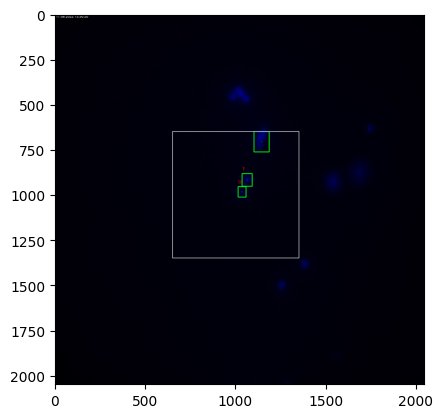

The picture showed 3 cell blobs.


In [7]:
roi_per_blob_id_center = global_layer_center(video_file_path, PICTURES_ON)

In [8]:
total_cell_number_center =  local_layer(roi_per_blob_id_center, PICTURES_ON = False)

The total cell number is: 3


In [9]:
## Final step: Add counted cells together

total_cell_number = total_cell_number_frame + total_cell_number_center

print("The total number of detected cells in the whole video is " + str(total_cell_number))

The total number of detected cells in the whole video is 21
